# 2 - Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imagenes de articulos de vestimenta, el Fashion MNIST. 


In [0]:
import numpy as np
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Reshape, UpSampling2D
from keras.models import Sequential, Model
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import torch
import keras.models
import json
import pickle

### 2.a Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`.

In [2]:
(x_train,y_train),(x_val,y_val) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


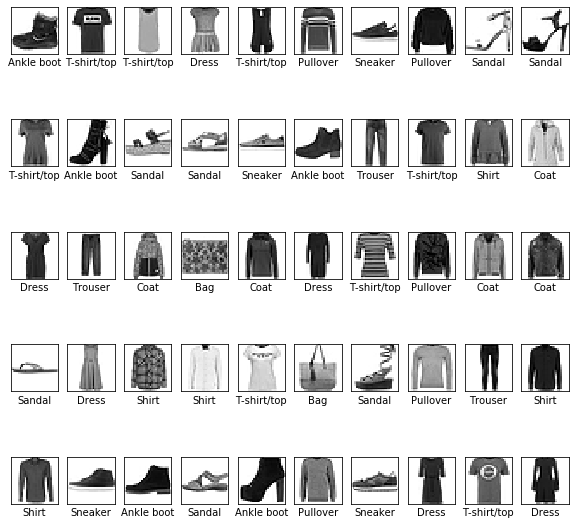

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación?
1. "Coat" y "Shirt" debido a que ambos son prendas de torso con manga larga.
2. "Sandal" y "Sneaker" pues algunos tienen forma parecida, solo que "Sandal" tienden a tener menos material.
3. "Dress" y "T-shirt/top" pues ambos son prendas de torso con manga corta.
4. "Coat" y "Pullover" por la misma razón que "Coat" y "Shirt."
5. "Pullover" y "Shirt" por la misma razón que "Coat" y "Shirt."
6. "Ankle boot" y algunos casos de "Sandal" debido que ambos pueden tener tacones.



#### ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?
La principal dificultad sería poder identificar la diferencia entre "Pullover", "Coat" y "Shirt" porque en blanco y negro las imágenes se ven muy parecidas, por lo que se piensa que la clasificación de estas categorías tendrán un error alto si un humano hace la clasificación.

### 2.b Posibilidades de preprocesamiento y pequeños análisis. 

####¿Cuáles son los rangos de valores de `x`? ¿Por qué?
El rango es de 0 a 255, pues se trata de los valores que pueden tomar los pixeles que forman las imágenes.

####¿Las distintas clases de ejemplos están balanceadas?


In [4]:
(clase, ocurrencia) = np.unique(y_train, return_counts=True)
frecuencia = np.asarray((clase, ocurrencia)).T
print(frecuencia)

[[   0 6000]
 [   1 6000]
 [   2 6000]
 [   3 6000]
 [   4 6000]
 [   5 6000]
 [   6 6000]
 [   7 6000]
 [   8 6000]
 [   9 6000]]


Como se puede apreciar, cada clase tiene 6000 ejemplos, por lo que las clases están balanceadas.

####¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 

Si, hay que estandarizar los valores de x para que sus valores se encuentren entre 0 y 1. Como estamos trabajando con autoencoders, los valores de las clases (labels) no nos son de importancia. Como siempre, hacer esta transformación inevitablemente causa una ligera pérdida de información debido a la limitación para almacenar los números luego de la división.


In [0]:
x_train_unchanged = x_train
x_val_unchanged = x_val
x_train = x_train / 255.0
x_val = x_val / 255.0

####Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

In [0]:
x_train_u_vector = x_train_unchanged.reshape(-1, 28*28)
x_val_u_vector = x_val_unchanged.reshape(-1, 28*28)
x_train_vector = x_train.reshape(-1,28*28)
x_val_vector = x_val.reshape(-1, 28*28)

### 2.c Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

####Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados, ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 
Deberíamos utilizar la función de activación sigmoidal para la capa de salida, pues necesitamos que los valores de output estén dentro del rango [0,1]. Si afecta pues esta determina los valores de nuestro output, o sea los valores de nuestra imagen reconstruida y que son utilizados para poder mejorar la calidad de nuestra codificación durante el entrenamiento.

####Entrene esta primera red utilizando pérdida _binary cross entropy_. 

In [0]:
autoencoder_2c = Sequential()

autoencoder_2c.add(Dense(32, input_dim=784, activation='relu')) # encoder
 
autoencoder_2c.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2c.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [183]:
history_2c = autoencoder_2c.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('2c_autoencoder.h5')

#with open('/2c_autoencoder_history', 'wb') as file_pi:
#       pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.2827 - acc: 0.5085 - val_loss: 0.2854 - val_acc: 0.5063
Epoch 2/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.2826 - acc: 0.5084 - val_loss: 0.2849 - val_acc: 0.5061
Epoch 3/20
60000/60000 [==============================] - 8s 128us/step - loss: 0.2826 - acc: 0.5084 - val_loss: 0.2849 - val_acc: 0.5063
Epoch 4/20
60000/60000 [==============================] - 8s 128us/step - loss: 0.2826 - acc: 0.5085 - val_loss: 0.2844 - val_acc: 0.5063
Epoch 5/20
60000/60000 [==============================] - 7s 125us/step - loss: 0.2825 - acc: 0.5085 - val_loss: 0.2855 - val_acc: 0.5064
Epoch 6/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.2825 - acc: 0.5084 - val_loss: 0.2856 - val_acc: 0.5062
Epoch 7/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.2825 - acc: 0.5085 - val_loss: 0.2845 - 

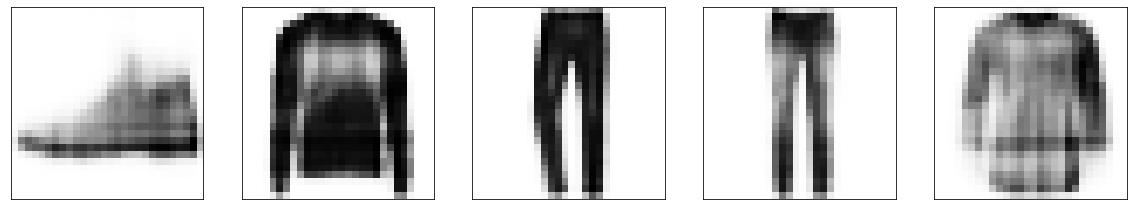

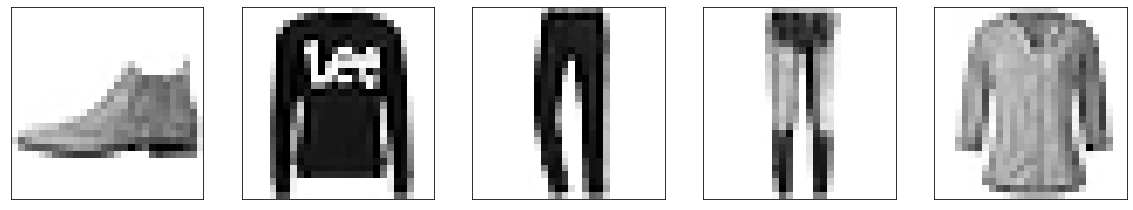

In [184]:
#autoencoder_2c = keras.models.load_model('2c_autoencoder.h5')

img_2c = autoencoder_2c.predict(x_val_vector)
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2c[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='Greys')
plt.show()

####Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion? 

El primer conjunto de imágenes corresponde a las imágenes reconstruidas mientras que el segundo corresponde a las imágenes originales. 

El desempeño de la red no es satisfactorio, pues se puede observar que hay muchos detalles que se pierden o la imágen se vuelve demasiado borrosa y causa que se vea como un artículo completamente distinto (por ejemplo la imagen 5 puede pasar como cualquier tipo de prenda de cuerpo).

####Grafique como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

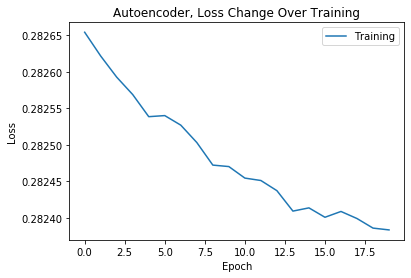

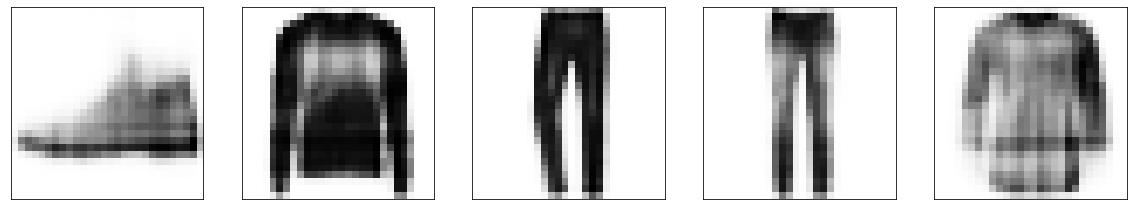

In [186]:
#history = pickle.load(open('/2c_autoencoder_history', 'rb'))

# Plot training & validation accuracy values
plt.plot(history_2c.history['loss'])
plt.title('Autoencoder 2c, Loss Change Over Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2c[i].reshape(28,28), cmap='Greys')
plt.show()

### 2.d Sin escalar
Entrene nuevamente la misma estructura de red pero esta vez utilizando los datos originales (sin escalar)

####¿Qué función de activación debe utilizar para la capa de salida?
A pesar de que ReLu es eficiente, sencillo y evita y rectifica el problema del vanishing gradient, tiene la limitación de que se debe utilizar en las hidden layers, por lo que para la capa de salida utilizamos ELU pues es se trata de un problema de regresión.

In [0]:
autoencoder_2d = Sequential()

autoencoder_2d.add(Dense(32, input_dim=784, activation='relu')) # encoder
 
autoencoder_2d.add(Dense(28*28,activation='elu')) #decoder

autoencoder_2d.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [187]:
history_2d = autoencoder_2d.fit(x_train_u_vector, x_train_u_vector, epochs=20, validation_data=(x_val_u_vector,x_val_u_vector), shuffle=True)
#autoencoder.save('2d_autoencoder.h5')

#with open('/2d_autoencoder_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 158us/step - loss: -1145.2271 - acc: 0.3029 - val_loss: -1149.2440 - val_acc: 0.3246
Epoch 2/20
60000/60000 [==============================] - 8s 135us/step - loss: -1146.0681 - acc: 0.3331 - val_loss: -1149.4854 - val_acc: 0.3354
Epoch 3/20
60000/60000 [==============================] - 8s 130us/step - loss: -1146.2326 - acc: 0.3389 - val_loss: -1149.5893 - val_acc: 0.3364
Epoch 4/20
60000/60000 [==============================] - 8s 136us/step - loss: -1146.3250 - acc: 0.3439 - val_loss: -1149.5458 - val_acc: 0.3473
Epoch 5/20
60000/60000 [==============================] - 8s 132us/step - loss: -1146.3510 - acc: 0.3465 - val_loss: -1149.5686 - val_acc: 0.3373
Epoch 6/20
60000/60000 [==============================] - 8s 129us/step - loss: -1146.3769 - acc: 0.3468 - val_loss: -1149.6819 - val_acc: 0.3408
Epoch 7/20
60000/60000 [==============================] - 8s 135us/step - 

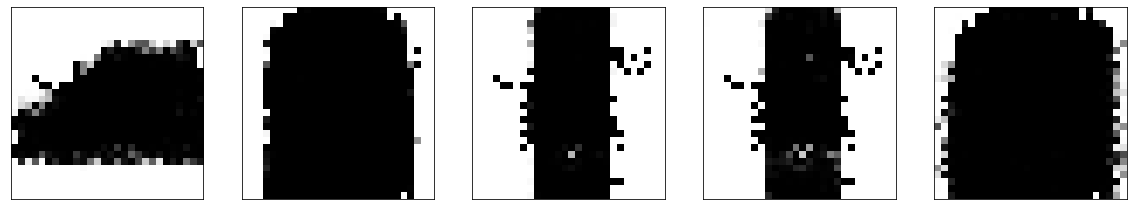

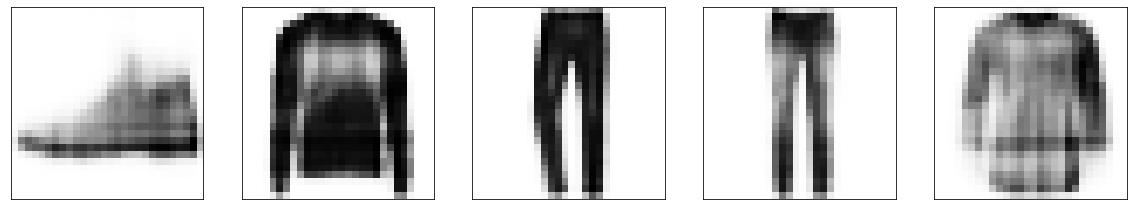

In [195]:
#autoencoder_2d = keras.models.load_model('2d_autoencoder.h5')

img_2d = autoencoder_2d.predict(x_val_vector)
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2d[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2c[i].reshape(28,28), cmap='Greys')
plt.show()

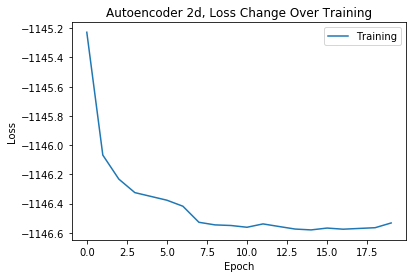

In [189]:
plt.plot(history_2d.history['loss'])
plt.title('Autoencoder 2d, Loss Change Over Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

####¿Le parece sea una buena aproximación comparando con las caracteristicas de la red anterior? Compare los desempeños viendo las imagenes reconstruidas. 
No, se pierde demasiada información y la pérdida se comienza a estancar cerca de la 20va epoch. Si se observan las imágenes, se verá que en el modelo 2d estas son manchones negros en comparación.


De aquí en adelante prefiera la versión de los datos escaladas para consistencia. 

### 2.e Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

In [0]:
autoencoder_2e_2 = Sequential()

autoencoder_2e_2.add(Dense(2, input_dim=784, activation='relu')) # encoder
 
autoencoder_2e_2.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2e_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [197]:
history_2e_2 = autoencoder_2e_2.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('autoencoder_2e_2.h5')

#with open('/autoencoder_2e_2_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 181us/step - loss: 0.4284 - acc: 0.4870 - val_loss: 0.4018 - val_acc: 0.4896
Epoch 2/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.3940 - acc: 0.4904 - val_loss: 0.3907 - val_acc: 0.4897
Epoch 3/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.3851 - acc: 0.4921 - val_loss: 0.3843 - val_acc: 0.4932
Epoch 4/20
60000/60000 [==============================] - 8s 129us/step - loss: 0.3800 - acc: 0.4940 - val_loss: 0.3813 - val_acc: 0.4944
Epoch 5/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.3781 - acc: 0.4946 - val_loss: 0.3803 - val_acc: 0.4947
Epoch 6/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.3772 - acc: 0.4946 - val_loss: 0.3788 - val_acc: 0.4912
Epoch 7/20
60000/60000 [==============================] - 8s 130us/step - loss: 0.3767 - acc: 0.4946 - val_loss: 0.3781 -

In [0]:
autoencoder_2e_20 = Sequential()

autoencoder_2e_20.add(Dense(20, input_dim=784, activation='relu')) # encoder
 
autoencoder_2e_20.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2e_20.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [199]:
history_2e_20 = autoencoder_2e_20.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('autoencoder_2e_20.h5')

#with open('/autoencoder_2e_20_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 180us/step - loss: 0.3339 - acc: 0.5010 - val_loss: 0.3050 - val_acc: 0.5043
Epoch 2/20
60000/60000 [==============================] - 8s 128us/step - loss: 0.2990 - acc: 0.5068 - val_loss: 0.2977 - val_acc: 0.5050
Epoch 3/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.2955 - acc: 0.5071 - val_loss: 0.2962 - val_acc: 0.5052
Epoch 4/20
60000/60000 [==============================] - 8s 128us/step - loss: 0.2943 - acc: 0.5073 - val_loss: 0.2969 - val_acc: 0.5056
Epoch 5/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.2936 - acc: 0.5073 - val_loss: 0.2959 - val_acc: 0.5055
Epoch 6/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.2931 - acc: 0.5073 - val_loss: 0.2945 - val_acc: 0.5054
Epoch 7/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.2927 - acc: 0.5073 - val_loss: 0.2944 -

In [0]:
autoencoder_2e_80 = Sequential()

autoencoder_2e_80.add(Dense(80, input_dim=784, activation='relu')) # encoder
 
autoencoder_2e_80.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2e_80.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [201]:
history_2e_80 = autoencoder_2e_80.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('autoencoder_2e_80.h5')

#with open('/autoencoder_2e_80_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 172us/step - loss: 0.3098 - acc: 0.5049 - val_loss: 0.2860 - val_acc: 0.5061
Epoch 2/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.2812 - acc: 0.5086 - val_loss: 0.2780 - val_acc: 0.5067
Epoch 3/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.2758 - acc: 0.5090 - val_loss: 0.2753 - val_acc: 0.5069
Epoch 4/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.2733 - acc: 0.5092 - val_loss: 0.2740 - val_acc: 0.5069
Epoch 5/20
60000/60000 [==============================] - 8s 129us/step - loss: 0.2719 - acc: 0.5093 - val_loss: 0.2749 - val_acc: 0.5072
Epoch 6/20
60000/60000 [==============================] - 7s 120us/step - loss: 0.2711 - acc: 0.5093 - val_loss: 0.2724 - val_acc: 0.5072
Epoch 7/20
60000/60000 [==============================] - 8s 128us/step - loss: 0.2705 - acc: 0.5094 - val_loss: 0.2715 -

In [0]:
autoencoder_2e_200 = Sequential()

autoencoder_2e_200.add(Dense(200, input_dim=784, activation='relu')) # encoder
 
autoencoder_2e_200.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2e_200.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [203]:
history_2e_200 = autoencoder_2e_200.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('autoencoder_2e_200.h5')

#with open('/autoencoder_2e_200_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 175us/step - loss: 0.2983 - acc: 0.5066 - val_loss: 0.2773 - val_acc: 0.5069
Epoch 2/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.2726 - acc: 0.5093 - val_loss: 0.2720 - val_acc: 0.5072
Epoch 3/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.2674 - acc: 0.5096 - val_loss: 0.2670 - val_acc: 0.5075
Epoch 4/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.2649 - acc: 0.5097 - val_loss: 0.2650 - val_acc: 0.5076
Epoch 5/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.2633 - acc: 0.5098 - val_loss: 0.2654 - val_acc: 0.5076
Epoch 6/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.2622 - acc: 0.5098 - val_loss: 0.2625 - val_acc: 0.5077
Epoch 7/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.2615 - acc: 0.5099 - val_loss: 0.2623 -

In [0]:
autoencoder_2e_392 = Sequential()

autoencoder_2e_392.add(Dense(392, input_dim=784, activation='relu')) # encoder
 
autoencoder_2e_392.add(Dense(28*28,activation='sigmoid')) #decoder

autoencoder_2e_392.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [205]:
history_2e_392 = autoencoder_2e_392.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)
#autoencoder.save('autoencoder_2e_392.h5')

#with open('/autoencoder_2e_392_history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 196us/step - loss: 0.2922 - acc: 0.5073 - val_loss: 0.2722 - val_acc: 0.5072
Epoch 2/20
60000/60000 [==============================] - 8s 136us/step - loss: 0.2681 - acc: 0.5096 - val_loss: 0.2665 - val_acc: 0.5076
Epoch 3/20
60000/60000 [==============================] - 8s 134us/step - loss: 0.2632 - acc: 0.5098 - val_loss: 0.2631 - val_acc: 0.5077
Epoch 4/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.2607 - acc: 0.5099 - val_loss: 0.2617 - val_acc: 0.5077
Epoch 5/20
60000/60000 [==============================] - 8s 136us/step - loss: 0.2591 - acc: 0.5100 - val_loss: 0.2607 - val_acc: 0.5078
Epoch 6/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.2581 - acc: 0.5100 - val_loss: 0.2609 - val_acc: 0.5078
Epoch 7/20
60000/60000 [==============================] - 8s 135us/step - loss: 0.2572 - acc: 0.5100 - val_loss: 0.2609 -

In [0]:
#autoencoder_2e_2 = keras.models.load_model('autoencoder_2e_2.h5')
#autoencoder_2e_20 = keras.models.load_model('autoencoder_2e_20.h5')
#autoencoder_2e_80 = keras.models.load_model('autoencoder_2e_80.h5')
#autoencoder_2e_200 = keras.models.load_model('autoencoder_2e_200.h5')
#autoencoder_2e_392 = keras.models.load_model('autoencoder_2e_392.h5')

img_2 = autoencoder_2e_2.predict(x_val_vector)
img_20 = autoencoder_2e_20.predict(x_val_vector)
img_80 = autoencoder_2e_80.predict(x_val_vector)
img_200 = autoencoder_2e_200.predict(x_val_vector)
img_392 = autoencoder_2e_392.predict(x_val_vector)

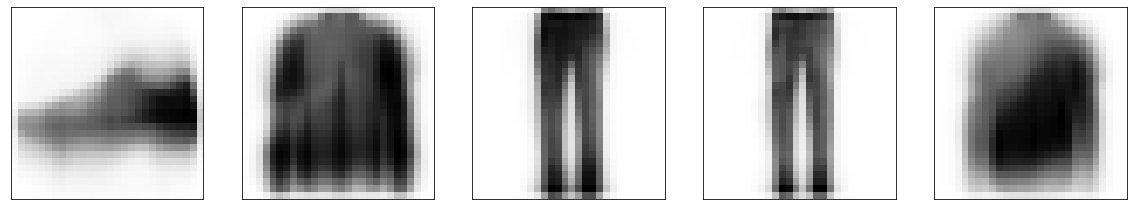

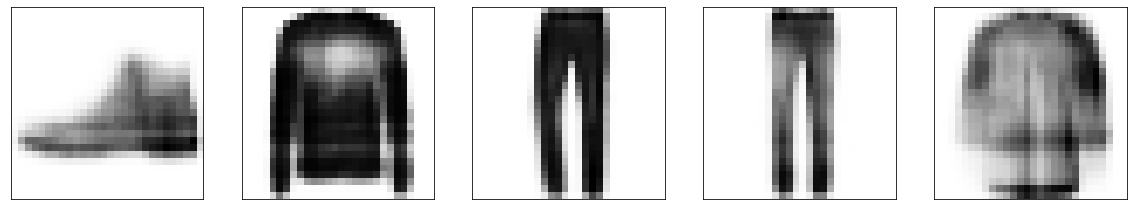

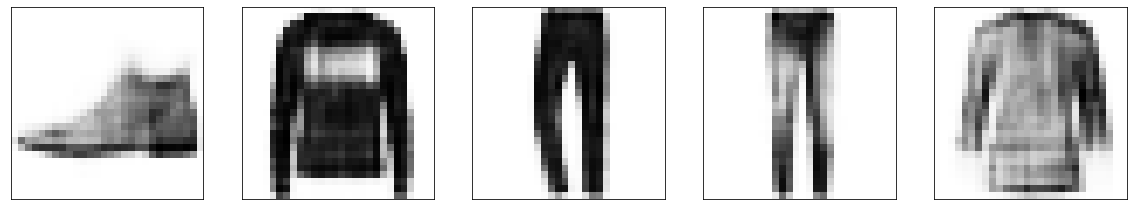

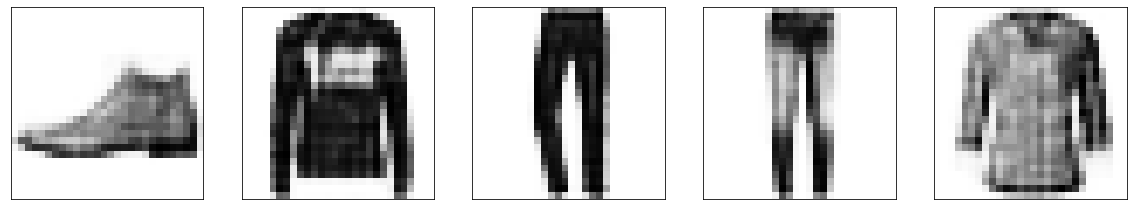

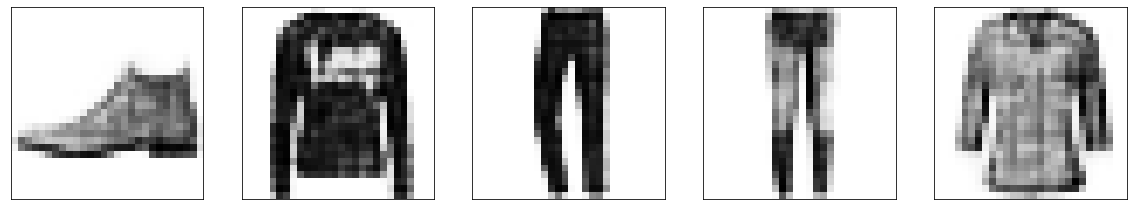

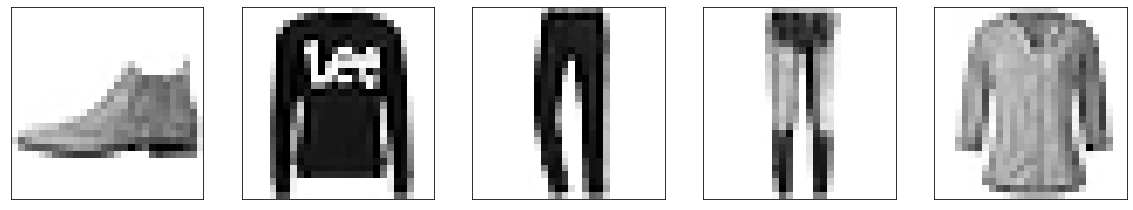

In [208]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_20[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_80[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_200[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_392[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='Greys')
plt.show()

###¿Qué observa?
Se observa que el error y la pérdida comienzan a disminuir a medida que aumentamos la cantidad de neuronas. Esto es lógico pues le estamos permitiendo al autoencoder mantener más información durante la compresión de la imagen, por lo que tiene más información durante la descompresión, generando una imagen más similar a la original y menos difuza.

### 2.f Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

In [0]:
autoencoder_2f_392 = Sequential()

autoencoder_2f_392.add(Dense(units=706, activation='relu', input_dim=784))
autoencoder_2f_392.add(Dense(units=627, activation='relu'))
autoencoder_2f_392.add(Dense(units=549, activation='relu'))
autoencoder_2f_392.add(Dense(units=470, activation='relu'))

autoencoder_2f_392.add(Dense(units=392, activation='relu'))

autoencoder_2f_392.add(Dense(units=470, activation='relu'))
autoencoder_2f_392.add(Dense(units=549, activation='relu'))
autoencoder_2f_392.add(Dense(units=627, activation='relu'))
autoencoder_2f_392.add(Dense(units=706, activation='relu'))
autoencoder_2f_392.add(Dense(units=784, activation='sigmoid'))

autoencoder_2f_392.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                        metrics=['accuracy'])


In [290]:
history_2f_392 = autoencoder_2f_392.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 323us/step - loss: 0.3432 - acc: 0.4980 - val_loss: 0.3104 - val_acc: 0.5006
Epoch 2/20
60000/60000 [==============================] - 14s 237us/step - loss: 0.3054 - acc: 0.5040 - val_loss: 0.3048 - val_acc: 0.5035
Epoch 3/20
60000/60000 [==============================] - 14s 228us/step - loss: 0.2976 - acc: 0.5052 - val_loss: 0.2990 - val_acc: 0.5037
Epoch 4/20
60000/60000 [==============================] - 14s 228us/step - loss: 0.2932 - acc: 0.5058 - val_loss: 0.2938 - val_acc: 0.5037
Epoch 5/20
60000/60000 [==============================] - 14s 226us/step - loss: 0.2907 - acc: 0.5062 - val_loss: 0.2932 - val_acc: 0.5031
Epoch 6/20
60000/60000 [==============================] - 14s 228us/step - loss: 0.2890 - acc: 0.5064 - val_loss: 0.2903 - val_acc: 0.5040
Epoch 7/20
60000/60000 [==============================] - 14s 236us/step - loss: 0.2878 - acc: 0.5065 - val_loss: 0.

In [0]:
img_2f_392 = autoencoder_2f_392.predict(x_val_vector)

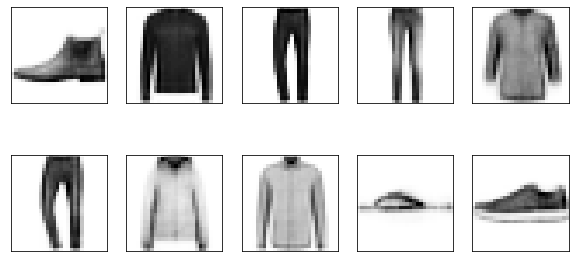

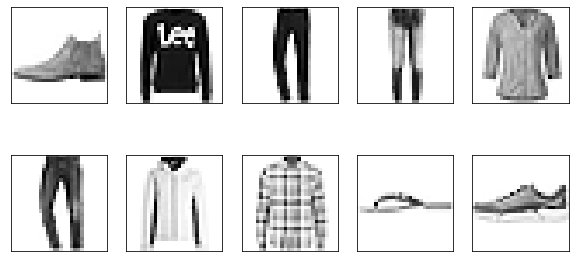

In [306]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_392[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='Greys')
plt.show()

In [295]:
print(autoencoder_2f_392.summary())

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_285 (Dense)            (None, 706)               554210    
_________________________________________________________________
dense_286 (Dense)            (None, 627)               443289    
_________________________________________________________________
dense_287 (Dense)            (None, 549)               344772    
_________________________________________________________________
dense_288 (Dense)            (None, 470)               258500    
_________________________________________________________________
dense_289 (Dense)            (None, 392)               184632    
_________________________________________________________________
dense_290 (Dense)            (None, 470)               184710    
_________________________________________________________________
dense_291 (Dense)            (None, 549)             

####¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

En nuestro modelo, capa a capa se redujo la cantidad de neuronas en un 5% del total de 784 (hasta llegar al 50% de la cantidad original, luego se vuelve a aumentar de a 5%) y por lo que se puede observar esto causa una reducción del 10% en la cantidad de parámetros en cada capa (un aumento del 10% cuando se aumenta la cantidad de neuronas en 5%). El tamaño de la representación "comprimida" siempre se mantiene del mismo tamaño, pues se decidió que esta iba a tener 392 neuronas que fue la cantidad que mejor dio resultados en la pregunta anterior.

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. 

In [0]:
autoencoder_2f_2 = Sequential()

autoencoder_2f_2.add(Dense(units=706, activation='relu', input_dim=784))
autoencoder_2f_2.add(Dense(units=627, activation='relu'))
autoencoder_2f_2.add(Dense(units=549, activation='relu'))
autoencoder_2f_2.add(Dense(units=470, activation='relu'))

autoencoder_2f_2.add(Dense(units=2, activation='relu'))

autoencoder_2f_2.add(Dense(units=470, activation='relu'))
autoencoder_2f_2.add(Dense(units=549, activation='relu'))
autoencoder_2f_2.add(Dense(units=627, activation='relu'))
autoencoder_2f_2.add(Dense(units=706, activation='relu'))
autoencoder_2f_2.add(Dense(units=784, activation='sigmoid'))

autoencoder_2f_2.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                        metrics=['accuracy'])

In [297]:
history_2f_2 = autoencoder_2f_2.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 317us/step - loss: 0.4921 - acc: 0.4870 - val_loss: 0.4913 - val_acc: 0.4860
Epoch 2/20
60000/60000 [==============================] - 14s 226us/step - loss: 0.4906 - acc: 0.4875 - val_loss: 0.4912 - val_acc: 0.4872
Epoch 3/20
60000/60000 [==============================] - 13s 223us/step - loss: 0.4905 - acc: 0.4877 - val_loss: 0.4913 - val_acc: 0.4839
Epoch 4/20
60000/60000 [==============================] - 14s 225us/step - loss: 0.4904 - acc: 0.4877 - val_loss: 0.4912 - val_acc: 0.4834
Epoch 5/20
60000/60000 [==============================] - 13s 225us/step - loss: 0.4904 - acc: 0.4877 - val_loss: 0.4912 - val_acc: 0.4866
Epoch 6/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.4904 - acc: 0.4877 - val_loss: 0.4912 - val_acc: 0.4873
Epoch 7/20
60000/60000 [==============================] - 14s 226us/step - loss: 0.4904 - acc: 0.4877 - val_loss: 0.

In [0]:
autoencoder_2f_20 = Sequential()

autoencoder_2f_20.add(Dense(units=706, activation='relu', input_dim=784))
autoencoder_2f_20.add(Dense(units=627, activation='relu'))
autoencoder_2f_20.add(Dense(units=549, activation='relu'))
autoencoder_2f_20.add(Dense(units=470, activation='relu'))

autoencoder_2f_20.add(Dense(units=20, activation='relu'))

autoencoder_2f_20.add(Dense(units=470, activation='relu'))
autoencoder_2f_20.add(Dense(units=549, activation='relu'))
autoencoder_2f_20.add(Dense(units=627, activation='relu'))
autoencoder_2f_20.add(Dense(units=706, activation='relu'))
autoencoder_2f_20.add(Dense(units=784, activation='sigmoid'))

autoencoder_2f_20.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                        metrics=['accuracy'])

In [299]:
history_2f_20 = autoencoder_2f_20.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 317us/step - loss: 0.3438 - acc: 0.4976 - val_loss: 0.3172 - val_acc: 0.4995
Epoch 2/20
60000/60000 [==============================] - 14s 227us/step - loss: 0.3055 - acc: 0.5040 - val_loss: 0.3025 - val_acc: 0.5038
Epoch 3/20
60000/60000 [==============================] - 13s 222us/step - loss: 0.2979 - acc: 0.5051 - val_loss: 0.2970 - val_acc: 0.5035
Epoch 4/20
60000/60000 [==============================] - 13s 225us/step - loss: 0.2940 - acc: 0.5057 - val_loss: 0.2939 - val_acc: 0.5039
Epoch 5/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.2914 - acc: 0.5061 - val_loss: 0.2930 - val_acc: 0.5043
Epoch 6/20
60000/60000 [==============================] - 14s 229us/step - loss: 0.2895 - acc: 0.5063 - val_loss: 0.2920 - val_acc: 0.5044
Epoch 7/20
60000/60000 [==============================] - 14s 232us/step - loss: 0.2881 - acc: 0.5065 - val_loss: 0.

In [0]:
autoencoder_2f_80 = Sequential()

autoencoder_2f_80.add(Dense(units=706, activation='relu', input_dim=784))
autoencoder_2f_80.add(Dense(units=627, activation='relu'))
autoencoder_2f_80.add(Dense(units=549, activation='relu'))
autoencoder_2f_80.add(Dense(units=470, activation='relu'))

autoencoder_2f_80.add(Dense(units=80, activation='relu'))

autoencoder_2f_80.add(Dense(units=470, activation='relu'))
autoencoder_2f_80.add(Dense(units=549, activation='relu'))
autoencoder_2f_80.add(Dense(units=627, activation='relu'))
autoencoder_2f_80.add(Dense(units=706, activation='relu'))
autoencoder_2f_80.add(Dense(units=784, activation='sigmoid'))

autoencoder_2f_80.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                        metrics=['accuracy'])

In [301]:
history_2f_80 = autoencoder_2f_80.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 342us/step - loss: 0.3423 - acc: 0.4978 - val_loss: 0.3149 - val_acc: 0.5003
Epoch 2/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.3051 - acc: 0.5040 - val_loss: 0.3021 - val_acc: 0.5027
Epoch 3/20
60000/60000 [==============================] - 15s 245us/step - loss: 0.2972 - acc: 0.5052 - val_loss: 0.2965 - val_acc: 0.5029
Epoch 4/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.2927 - acc: 0.5059 - val_loss: 0.2934 - val_acc: 0.5044
Epoch 5/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.2900 - acc: 0.5063 - val_loss: 0.2911 - val_acc: 0.5041
Epoch 6/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.2882 - acc: 0.5065 - val_loss: 0.2895 - val_acc: 0.5040
Epoch 7/20
60000/60000 [==============================] - 15s 249us/step - loss: 0.2870 - acc: 0.5067 - val_loss: 0.

In [0]:
autoencoder_2f_200 = Sequential()

autoencoder_2f_200.add(Dense(units=706, activation='relu', input_dim=784))
autoencoder_2f_200.add(Dense(units=627, activation='relu'))
autoencoder_2f_200.add(Dense(units=549, activation='relu'))
autoencoder_2f_200.add(Dense(units=470, activation='relu'))

autoencoder_2f_200.add(Dense(units=200, activation='relu'))

autoencoder_2f_200.add(Dense(units=470, activation='relu'))
autoencoder_2f_200.add(Dense(units=549, activation='relu'))
autoencoder_2f_200.add(Dense(units=627, activation='relu'))
autoencoder_2f_200.add(Dense(units=706, activation='relu'))
autoencoder_2f_200.add(Dense(units=784, activation='sigmoid'))

autoencoder_2f_200.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                        metrics=['accuracy'])

In [303]:
history_2f_200 = autoencoder_2f_200.fit(x_train_vector, x_train_vector, epochs=20, validation_data=(x_val_vector,x_val_vector), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 362us/step - loss: 0.3430 - acc: 0.4979 - val_loss: 0.3108 - val_acc: 0.5021
Epoch 2/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.3054 - acc: 0.5040 - val_loss: 0.3013 - val_acc: 0.5026
Epoch 3/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.2977 - acc: 0.5052 - val_loss: 0.2966 - val_acc: 0.5036
Epoch 4/20
60000/60000 [==============================] - 14s 237us/step - loss: 0.2935 - acc: 0.5058 - val_loss: 0.2930 - val_acc: 0.5042
Epoch 5/20
60000/60000 [==============================] - 14s 236us/step - loss: 0.2910 - acc: 0.5062 - val_loss: 0.2911 - val_acc: 0.5041
Epoch 6/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.2894 - acc: 0.5064 - val_loss: 0.2907 - val_acc: 0.5044
Epoch 7/20
60000/60000 [==============================] - 14s 238us/step - loss: 0.2882 - acc: 0.5065 - val_loss: 0.

In [0]:
img_2f_2 = autoencoder_2f_2.predict(x_val_vector)
img_2f_20 = autoencoder_2f_20.predict(x_val_vector)
img_2f_80 = autoencoder_2f_80.predict(x_val_vector)
img_2f_200 = autoencoder_2f_200.predict(x_val_vector)

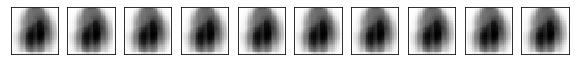

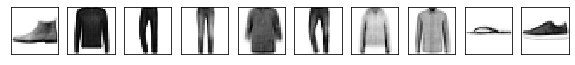

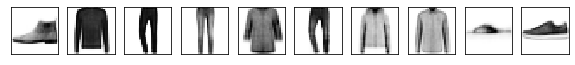

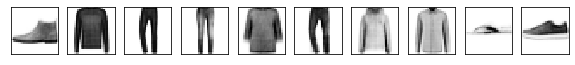

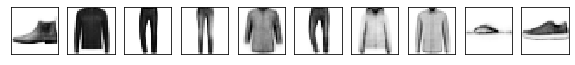

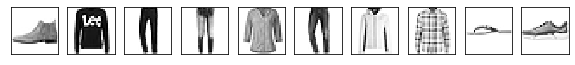

In [307]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_2[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_20[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_80[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_200[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_392[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='Greys')
plt.show()

####¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas? Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 
Si, podríamos utilizar una representación con dimensionalidad 20 en vez de 392 y obtener resultados bastante similares (ver imágenes de arriba y gráfico abajo)

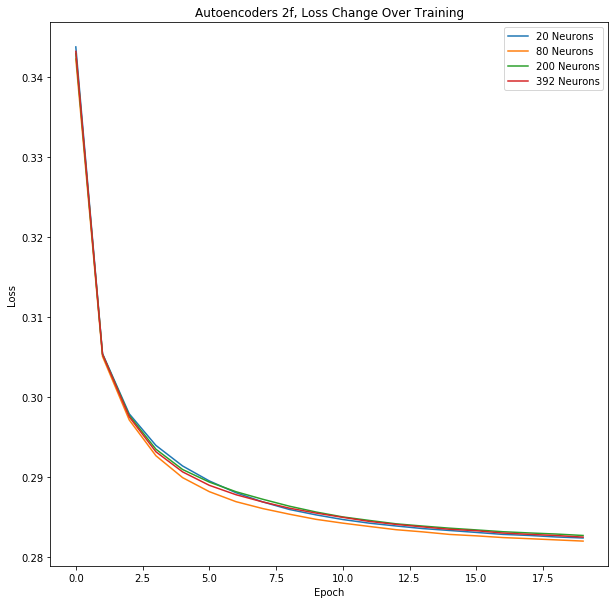

In [315]:
plt.figure(figsize=(10,10))
plt.plot(history_2f_20.history['loss'])
plt.plot(history_2f_80.history['loss'])
plt.plot(history_2f_200.history['loss'])
plt.plot(history_2f_392.history['loss'])
plt.title('Autoencoders 2f, Loss Change Over Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['20 Neurons', '80 Neurons', '200 Neurons', '392 Neurons'], loc='upper right')
plt.show()

###2.g Convolutional Autoencoder
Como hemos hasta ahora utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes.

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso.

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo stride=2 puede duplicar la dimensionalidad de su input.

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar output_padding para corregir problemas de paridad, entre otros.

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa Flatten y al final de ella una capa Reshape (keras.layers.Reshape(target_shape)) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa.

In [0]:
autoencoder_2g = Sequential()

autoencoder_2g.add(Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          padding='same', 
                          activation='relu', 
                          input_shape=(28, 28, 1)))
autoencoder_2g.add(MaxPooling2D((2, 2)))
autoencoder_2g.add(Conv2D(filters=8, 
                          kernel_size=(3, 3),
                          padding='same', 
                          activation='relu'))
autoencoder_2g.add(MaxPooling2D((2, 2)))

autoencoder_2g.add(Conv2D(filters=8, 
                          kernel_size=(3, 3),
                          padding='same', 
                          activation='relu'))
autoencoder_2g.add(UpSampling2D(size=(2,2)))
autoencoder_2g.add(Conv2D(filters=8, 
                          kernel_size=(3, 3),
                          padding='same', 
                          activation='relu'))
autoencoder_2g.add(UpSampling2D(size=(2,2)))
autoencoder_2g.add(Conv2D(filters=1, 
                          kernel_size=(3, 3),
                          padding='same', 
                          activation='sigmoid'))


autoencoder_2g.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy'])

In [349]:
x_train_g = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val_g = np.reshape(x_val, (len(x_val), 28, 28, 1))  

history_2g = autoencoder_2g.fit(x_train_g, x_train_g, epochs=20, validation_data=(x_val_g,x_val_g), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 28s 459us/step - loss: 0.2945 - acc: 0.5070 - val_loss: 0.2783 - val_acc: 0.5061
Epoch 2/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.2737 - acc: 0.5085 - val_loss: 0.2739 - val_acc: 0.5065
Epoch 3/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.2704 - acc: 0.5088 - val_loss: 0.2711 - val_acc: 0.5067
Epoch 4/20
60000/60000 [==============================] - 15s 243us/step - loss: 0.2681 - acc: 0.5090 - val_loss: 0.2693 - val_acc: 0.5068
Epoch 5/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.2665 - acc: 0.5091 - val_loss: 0.2681 - val_acc: 0.5071
Epoch 6/20
60000/60000 [==============================] - 14s 241us/step - loss: 0.2651 - acc: 0.5093 - val_loss: 0.2665 - val_acc: 0.5071
Epoch 7/20
60000/60000 [==============================] - 14s 239us/step - loss: 0.2640 - acc: 0.5094 - val_loss: 0.

In [350]:
print(autoencoder_2g.summary()) 

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 8)       

In [0]:
img_2g = autoencoder_2g.predict(x_val_g)

####Comparamos nuestro autoencoder convolucional con el mejor autoencoder denso de la pregunta anterior (el de 20 neuronas)

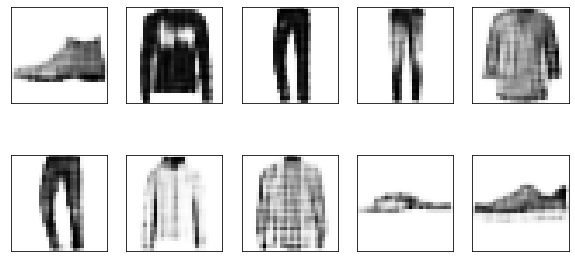

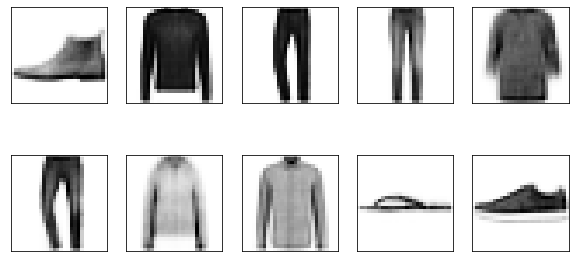

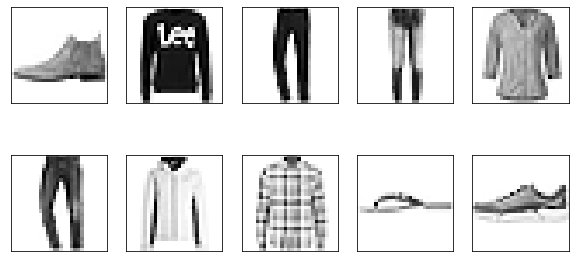

In [361]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2g[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2f_20[i].reshape(28,28), cmap='Greys')
plt.show()

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i], cmap='Greys')
plt.show()

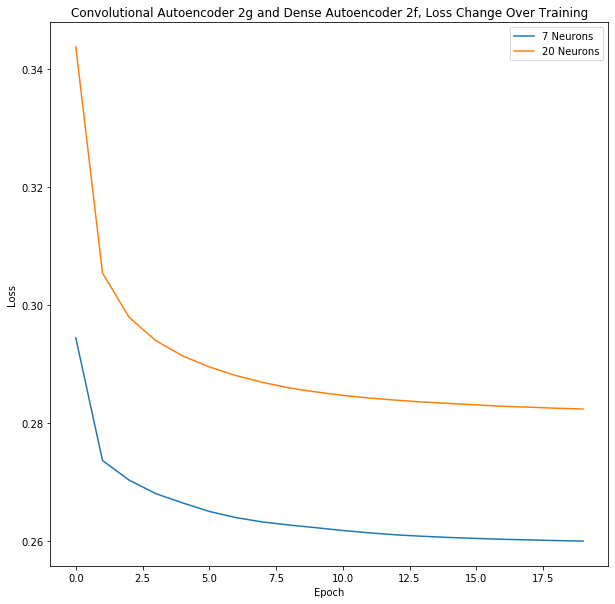

In [362]:
plt.figure(figsize=(10,10))
plt.plot(history_2g.history['loss'])
plt.plot(history_2f_20.history['loss'])
plt.title('Convolutional Autoencoder 2g and Dense Autoencoder 2f, Loss Change Over Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['7 Neurons', '20 Neurons'], loc='upper right')
plt.show()

####Como podemos ver, nuestro autoencoder convolucional presenta menos pérdida, la cual se nota al ver las imágenes las cuales logran mantener ciertos detalles que el autoencoder denso no lograba (generalmente los detalles se difuminaban).

###2.h Transfer Learning y reducción de dimensionalidad
Como mencionamos inicialmente, una de las utilidades de los autoencoders corresponde a la no necesidad de tener etiquetas. En ese caso, podemos utilizar los autoencoders para extraer representaciones significativas de los ejemplos no etiquetados, y luego utilizar ese conocimiento para mejorar el desempeño de nuestros algoritmos.

Para simular esta tarea supongamos que tenemos la misma base de datos original, sin embargo solo poseemos un pequeño porcentaje de las etiquetas del conjunto de entrenamiento, menos del  5%  (considere que si tuviera que etiquetar manualmente incluso solo un  5%  correspondería a 3000 imagenes por etiquetar!).

Seleccione un subconjunto de datos correspondiente a menos del  5%  de los datos y entrene un modelo predictivo para el problema de clasificación. Si bien la aproximación convolucional suele ser la mejor para este tipo de bases de datos, utilice arquitectura densa.



In [0]:
x_train_vector_5 = x_train_vector[:3000]
y_train_vector_5 = to_categorical(y_train[:3000])
y_val_vector = to_categorical(y_val)

model_2h = Sequential()

model_2h.add(Dense(600, activation='relu', input_dim=784))
model_2h.add(Dense(400, activation='relu'))
model_2h.add(Dense(200, activation='relu'))
model_2h.add(Dense(100, activation='relu'))
model_2h.add(Dense(10, activation ='softmax'))

model_2h.compile(optimizer='adam', loss='categorical_crossentropy', 
                        metrics=['accuracy'])


In [26]:
history_m_2h = model_2h.fit(x=x_train_vector_5, y=y_train_vector_5, epochs=20, validation_data=(x_val_vector, y_val_vector), shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3000 samples, validate on 10000 samples
Epoch 1/20





3000/3000 [==============================] - 20s 7ms/step - loss: 0.9377 - acc: 0.6520 - val_loss: 0.6577 - val_acc: 0.7570
Epoch 2/20
3000/3000 [==============================] - 1s 273us/step - loss: 0.5837 - acc: 0.7870 - val_loss: 0.5992 - val_acc: 0.7808
Epoch 3/20
3000/3000 [==============================] - 1s 281us/step - loss: 0.4768 - acc: 0.8260 - val_loss: 0.5666 - val_acc: 0.7933
Epoch 4/20
3000/3000 [==============================] - 1s 275us/step - loss: 0.4653 - acc: 0.8310 - val_loss: 0.5706 - val_acc: 0.7989
Epoch 5/20
3000/3000 [==============================] - 1s 288us/step - loss: 0.4279 - acc: 0.8357 - val_loss: 0.7444 - val_acc: 0.7592
Epoch 6/20
3000/3000 [==============================] - 1s 280us/step - loss: 0.3985 - acc: 0.8560 - val_loss: 0.5655 - val_acc: 0.8113
Epoch 7/20
3000/3000 [============

In [70]:
print(model_2h.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 600)               471000    
_________________________________________________________________
dense_28 (Dense)             (None, 400)               240400    
_________________________________________________________________
dense_29 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1010      
Total params: 812,710
Trainable params: 812,710
Non-trainable params: 0
_________________________________________________________________
None


Luego, utilizando el mejor autoencoder entrenado hasta ahora (o entrene uno nuevo si prefiere), utilize lo aprendido por la red sobre el conjunto de datos sin etiquetas para intentar aprender la relación suyaciente. Para esto, lo más fácil es primero preprocesar el conjunto x de entrenamiento, utilizando la sección de encoding de su autoencoder. Puede crear un nuevo modelo secuencial solo con las capas de encoding como se muestra en el código y luego usar el método .predict del modelo. Luego sobre estos datos preprocesados entrene un nuevo modelo predictivo fully connected.

La otra opción sería crear un modelo cuya primeras capas correspondan a la sección de encoding del autoencoder y las últimas capas a su modelo denso, pero fijando el atributo trainable de las primeras capas como False, sin embargo esto resulta poco eficiente.



In [51]:
x_train_g = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val_g = np.reshape(x_val, (len(x_val), 28, 28, 1)) 

encoder_2h = Sequential()

encoder_2h.add(Dense(units=706, activation='relu', input_dim=784))
encoder_2h.add(Dense(units=627, activation='relu'))
encoder_2h.add(Dense(units=549, activation='relu'))
encoder_2h.add(Dense(units=470, activation='relu'))

encoder_2h.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy'])
print(encoder_2h.summary()) 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 706)               554210    
_________________________________________________________________
dense_43 (Dense)             (None, 627)               443289    
_________________________________________________________________
dense_44 (Dense)             (None, 549)               344772    
_________________________________________________________________
dense_45 (Dense)             (None, 470)               258500    
Total params: 1,600,771
Trainable params: 1,600,771
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
prediction_e_2h = encoder_2h.predict(x_train_vector)

(60000, 470)


In [67]:
y_train_vector = to_categorical(y_train)

model_2h_470 = Sequential()

model_2h_470.add(Dense(470, activation='relu', input_dim=470))
model_2h_470.add(Dense(400, activation='relu'))
model_2h_470.add(Dense(200, activation='relu'))
model_2h_470.add(Dense(100, activation='relu'))
model_2h_470.add(Dense(10, activation ='softmax'))

model_2h_470.compile(optimizer='adam', loss='categorical_crossentropy', 
                        metrics=['accuracy'])

history_m_2h_470 = model_2h_470.fit(x=prediction_e_2h, y=y_train_vector, epochs=20, shuffle=True)

Epoch 1/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.6022 - acc: 0.7788
Epoch 2/20
60000/60000 [==============================] - 8s 137us/step - loss: 0.4558 - acc: 0.8312
Epoch 3/20
60000/60000 [==============================] - 8s 136us/step - loss: 0.4190 - acc: 0.8442
Epoch 4/20
60000/60000 [==============================] - 8s 130us/step - loss: 0.3874 - acc: 0.8552
Epoch 5/20
60000/60000 [==============================] - 8s 129us/step - loss: 0.3668 - acc: 0.8626
Epoch 6/20
60000/60000 [==============================] - 8s 134us/step - loss: 0.3496 - acc: 0.8689
Epoch 7/20
60000/60000 [==============================] - 8s 138us/step - loss: 0.3349 - acc: 0.8730
Epoch 8/20
60000/60000 [==============================] - 8s 130us/step - loss: 0.3187 - acc: 0.8791
Epoch 9/20
60000/60000 [==============================] - 8s 138us/step - loss: 0.3055 - acc: 0.8846
Epoch 10/20
60000/60000 [==============================] - 8s 136us/step - loss: 0.2960 - a

In [69]:
print(model_2h_470.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 470)               221370    
_________________________________________________________________
dense_67 (Dense)             (None, 400)               188400    
_________________________________________________________________
dense_68 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_69 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_70 (Dense)             (None, 10)                1010      
Total params: 511,080
Trainable params: 511,080
Non-trainable params: 0
_________________________________________________________________
None


Comente sus resultados basándose en métricas adecuadas. Comente igualmente sobre la dimensionalidad de las representaciones utilizadas por cada uno de los dos modelos entrenados en esta sección y el número de parametros entrenables y totales del modelo (considerando el encoding).

Nuestro segundo modelo tiene más parámetros totales y entrenables (2.111.851) que el primero (812.710). Además, nuestro segundo modelo toma un input de dimension 1x470 para poder manejar el output del encoder, mientras que el primer modelo recibe input de dimension 1x784. Ambos modelos tienen un output de dimension 1x10 para representar la categorización.

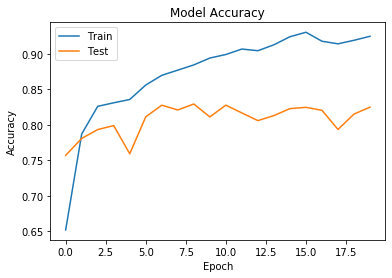

In [61]:
plt.plot(history_m_2h.history['acc'])
plt.plot(history_m_2h.history['val_acc'])
plt.title('Model Accuracy, Dense Network')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

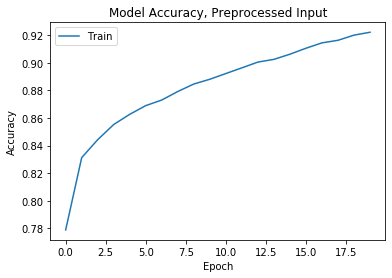

In [68]:
plt.plot(history_m_2h_470.history['acc'])
plt.title('Model Accuracy, Preprocessed Input')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Considerando la dimensionalidad obtenida por el encoder, compare la calidad de la representación obtenida por el autoencoder frente a otras aproximaciones de reducción de dimensionalidad, como por ejemplo Principal Component Analysis (PCA). Para esto, transforme los datos de entrenamiento utilizando PCA con un número de componentes principales igual a la dimensión de la representación engendrada por su encoder. Compare el desempeño de un modelo determinado utilizando ambas representaciones.

Comente sus resultados.